## Module 3 Project - Tanzania Water Well Prediction
The purpose of this project is to build a classification model to predict the conditions of water well in Tanzania. The target will be classify into one of the three categories-

- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

To build this classifier I will be using the data from Taarifa and the Tanzanian Ministry of Water. I will be using the OSEMN framework steps

1. Obtain the data
2. Scrub the data
3. Explore the data
4. Model the model
5. Interpret the data

First I will import some of the tools I will be using.

In [ ]:
# Importing all the libraries that I need 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm




# Obtain the Data
The data available for us are three csv files

- Test set values: The independent variables that need predictions
- Training set labels: The dependent variable (status_group) for each of the rows in Training set values
- Training set values: The independent variables for the training set

Since the test set values are meant to be submitted to a competition, the labels is available to us. So I will have to split the training set data to test the models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
features = pd.read_csv('/content/training_set_values.csv')
target = pd.read_csv('/content/training_set_labels.csv')
df = pd.merge(features, target, on='id', how='inner')

In [9]:
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [10]:
features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
display(df.head())
print(len(df))

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


59400


In [11]:
##Plot function for Confusion Matrix

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

I will first print out all the column discription to see which columns will be useful.

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

# Scrubbing The Data
First I will drops some columns which seems irrelevant for our purpose.

In [ ]:
df = df.drop(columns=['date_recorded', 'funder', 'wpt_name', 'recorded_by'], axis=1)

I also noticed that some of the labels have the same or similar discriptions. So I will be checking these to see if the columns are duplicates and if I can get rid of some of them.

- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed


- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses


- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water


- water_quality - The quality of the water
- quality_group - The quality of the water


- quantity - The quantity of water
- quantity_group - The quantity of water.


- payment - What the water costs
- payment_type - What the water costs


- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

First I will build a function that takes in a list and easily let me check the values.

In [ ]:
def check_unique(l):
  '''
  l: list or column of dataframe
  
  check the Feature Name, Number of Unique Values, Number of Missing Values, Unique Values

  '''
  for i in l:
      print("Feature Name:", i)
      print("Number of Unique Values:", len(df[i].unique()))
      print("Unique Values:", df[i].unique())
      print("Missing Values:", df[i].isna().sum())
      print('\n')

In [ ]:
check_unique(['scheme_management', 'scheme_name', 'management', 'management_group'])

Feature Name: scheme_management
Number of Unique Values: 13
Unique Values: ['VWC' 'Other' nan 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']
Missing Values: 3877


Feature Name: scheme_name
Number of Unique Values: 2697
Unique Values: ['Roman' nan 'Nyumba ya mungu pipe scheme' ... 'BL Nsherehehe'
 'Magati  gravity spri' 'Mtawanya']
Missing Values: 28166


Feature Name: management
Number of Unique Values: 12
Unique Values: ['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
Missing Values: 0


Feature Name: management_group
Number of Unique Values: 5
Unique Values: ['user-group' 'other' 'commercial' 'parastatal' 'unknown']
Missing Values: 0




scheme_management and management have similars values. scheme_management uses 'None' and 'nan' for missing values while managment uses 'unknown'. scheme_management also have the value 'SWC' which isn't in management, therefore I will drop the management column.  I will also drop the scheme_name columns since it contain 2697 unique string values which will be too much when creating dummies variables.

After that I will check the next set of columns..

In [ ]:
df = df.drop(columns=['management', 'scheme_name'], axis=1)

In [ ]:
check_unique(['extraction_type', 'extraction_type_group', 'extraction_type_class'])

Feature Name: extraction_type
Number of Unique Values: 18
Unique Values: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
Missing Values: 0


Feature Name: extraction_type_group
Number of Unique Values: 13
Unique Values: ['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
Missing Values: 0


Feature Name: extraction_type_class
Number of Unique Values: 7
Unique Values: ['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
Missing Values: 0




In [ ]:
df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

All three columns have the same values except extraction_type has 18 unique values while  extraction_type_group and extraction_type_class only have 13 and 7 respectively. Since the total sum of values for the five extra categories in extraction_type isn't alot, I will use the extraction_type_group for my model.                               

In [ ]:
df = df.drop(columns=['extraction_type', 'extraction_type_class'], axis=1)

In [ ]:
check_unique(['source', 'source_type', 'source_class'])

Feature Name: source
Number of Unique Values: 10
Unique Values: ['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
Missing Values: 0


Feature Name: source_type
Number of Unique Values: 7
Unique Values: ['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
Missing Values: 0


Feature Name: source_class
Number of Unique Values: 3
Unique Values: ['groundwater' 'surface' 'unknown']
Missing Values: 0




These three categories all have similar values also. 'source_class' have only 3 categories while 'source_type' and 'source' have 7 and 10 categories. Since the subcategories are quiet diffrent I will use the source column.

In [ ]:
df = df.drop(columns=['source_type', 'source_class'], axis=1)

In [ ]:
check_unique(['water_quality', 'quality_group'])

Feature Name: water_quality
Number of Unique Values: 8
Unique Values: ['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
Missing Values: 0


Feature Name: quality_group
Number of Unique Values: 6
Unique Values: ['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']
Missing Values: 0




These two columns also have similar values. 'water_quality' column have the value 'soft' instead of 'good' and also contained two extra categories of 'salty abandoned' and 'fluoride abandoned'. Since these categories insinuate a non_funtional water well, it could be imporatant for our model. So we will keep the 'water_quality' column.

In [ ]:
df = df.drop(columns=['quality_group'], axis=1)

In [ ]:
check_unique(['quantity', 'quantity_group'])

Feature Name: quantity
Number of Unique Values: 5
Unique Values: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
Missing Values: 0


Feature Name: quantity_group
Number of Unique Values: 5
Unique Values: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
Missing Values: 0




These two columns are exactly the same so I will get rid of one of them.

In [ ]:
df = df.drop(columns=['quantity_group'], axis=1)

In [ ]:
check_unique(['payment', 'payment_type'])

Feature Name: payment
Number of Unique Values: 7
Unique Values: ['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
Missing Values: 0


Feature Name: payment_type
Number of Unique Values: 7
Unique Values: ['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
Missing Values: 0




Both features have identical values. So, I will just keep one column snd remove the other one.



In [ ]:
df = df.drop(columns=['payment'], axis=1)

In [ ]:
check_unique(['waterpoint_type', 'waterpoint_type_group' ])

Feature Name: waterpoint_type
Number of Unique Values: 7
Unique Values: ['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
Missing Values: 0


Feature Name: waterpoint_type_group
Number of Unique Values: 6
Unique Values: ['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']
Missing Values: 0




The two column have similar values except waterpoint_type have a sub categories of 'communal standpipe multiple'. Since this category could be important for our model we will keep the columns with the extra sub-category ('waterpoint_feature').

In [ ]:
df = df.drop(columns=['waterpoint_type_group'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   num_private            59400 non-null  int64  
 8   basin                  59400 non-null  object 
 9   subvillage             59029 non-null  object 
 10  region                 59400 non-null  object 
 11  region_code            59400 non-null  int64  
 12  district_code          59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  ward                   59400 non-null  object 
 15  po

Next I will check the other columns with object type values. The first of these is 'installer' which could be important to our model since it might affect the quality of the water point.

In [ ]:
print(df['installer'].value_counts())
print(df['installer'].nunique())

DWE               17402
Government         1825
RWE                1206
Commu              1060
DANIDA             1050
                  ...  
Ilaramataki           1
AQUA Wat              1
Said Omari            1
Tarangire park        1
Privat                1
Name: installer, Length: 2145, dtype: int64
2145


Since there are 2145 diffrent unique and discrete values it is impossible to use the column, so I will have to get rid of it.

In [ ]:
df = df.drop(columns=['installer'], axis=1)

'permit' and 'public_meeting' contain boolean values and some missing data that will have to be dealt with later. First I will take a look at all the columns that contain geographical information.

- longitude - GPS coordinate 
- latitude - GPS coordinate 
- basin - Geographic water basin 
- subvillage - Geographic location 
- region - Geographic location 
- region_code - Geographic location (coded) 
- district_code - Geographic location (coded) 
- lga - Geographic location 
- ward - Geographic location

In [ ]:
geo_columns = ['longitude', 'latitude', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']
check_unique(geo_columns)


Feature Name: longitude
Number of Unique Values: 57516
Unique Values: [34.93809275 34.6987661  37.46066446 ... 34.01708706 35.86131531
 38.10404822]
Missing Values: 0


Feature Name: latitude
Number of Unique Values: 57517
Unique Values: [-9.85632177 -2.14746569 -3.82132853 ... -8.75043433 -6.37857327
 -6.74746425]
Missing Values: 0


Feature Name: basin
Number of Unique Values: 9
Unique Values: ['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
Missing Values: 0


Feature Name: subvillage
Number of Unique Values: 19288
Unique Values: ['Mnyusi B' 'Nyamara' 'Majengo' ... 'Itete B' 'Maore Kati' 'Kikatanyemba']
Missing Values: 371


Feature Name: region
Number of Unique Values: 21
Unique Values: ['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']
Missing Val

The features "longitude", "latitude", "subvillage", "lga" and "ward" all contain a large number of unique discrete values so they will not be very useful for our classifier so I will get rid of them.

In [ ]:
df = df.drop(columns=['longitude', 'latitude', 'subvillage', 'ward', 'lga'], axis=1)


In [ ]:
df.columns

Index(['id', 'status_group', 'amount_tsh', 'gps_height', 'num_private',
       'basin', 'region', 'region_code', 'district_code', 'population',
       'public_meeting', 'scheme_management', 'permit', 'construction_year',
       'extraction_type_group', 'management_group', 'payment_type',
       'water_quality', 'quantity', 'source', 'waterpoint_type'],
      dtype='object')

The remaining geographical columns are 'basin', 'region', 'region_code', 'district_code', and 'lga'. Since 'region_code' is only a numerical code of region, I will get rid of it. Then I will take a look at the five point summary for the columns with numerical data.

In [ ]:
df = df.drop(columns=['region_code'], axis=1)
#Change district code into object TESTINGTESTING
df['district_code'] = df['district_code'].astype(str) 


# Scrubbing Data - Dealing with Outliers

In [ ]:
df.describe()

,id,amount_tsh,gps_height,num_private,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,0.474141,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,12.236230,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,0.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,0.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,1776.000000,30500.000000,2013.000000


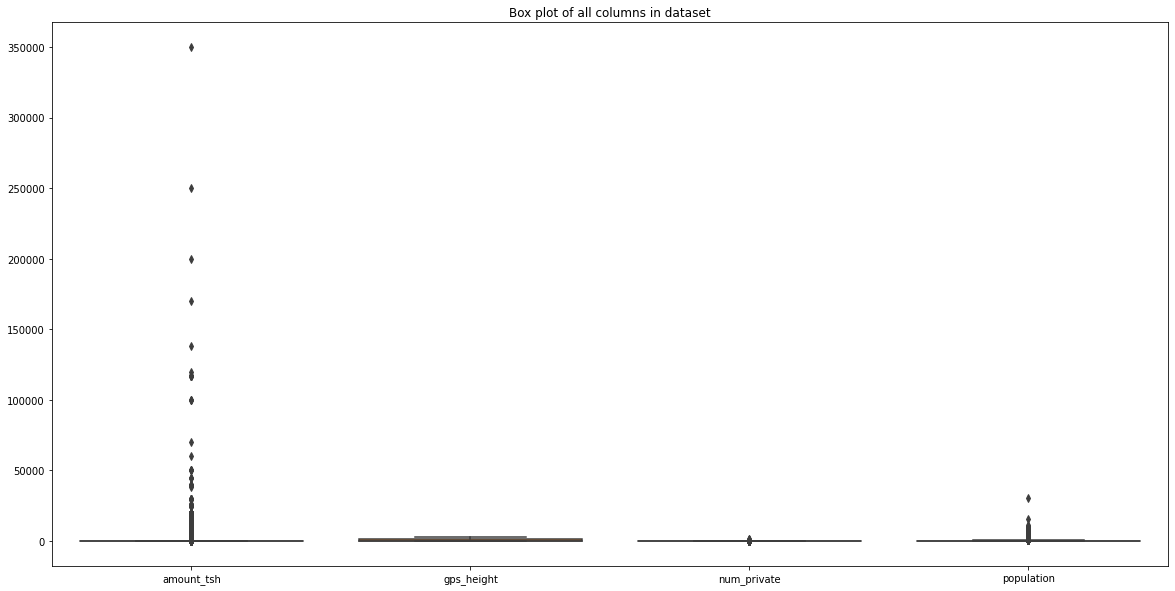

In [ ]:
cont_col = ['amount_tsh', 'gps_height', 'num_private', 'population']
plt.figure(figsize=(20, 10))
sns.boxplot(data=[df[col] for col in cont_col])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(0,4), cont_col)
plt.show()

It seems that the amount_tsh column contains very large outliers in the upper bounds, and the population columns also contain some large outliers. Therefore I will remove the outliers while trying out different percentile.

In [ ]:
#Remove population outliers in the upper bounds
# q_hi2  = df["population"].quantile(0.90)
# df = df[(df["population"] < q_hi2)]
q_hi2  = df["population"].quantile(0.80)
df = df[(df["population"] < q_hi2)]

#Remove amount_tsh outliers in the upper bounds
q_hi  = df["amount_tsh"].quantile(0.85)
df = df[(df["amount_tsh"] < q_hi)]


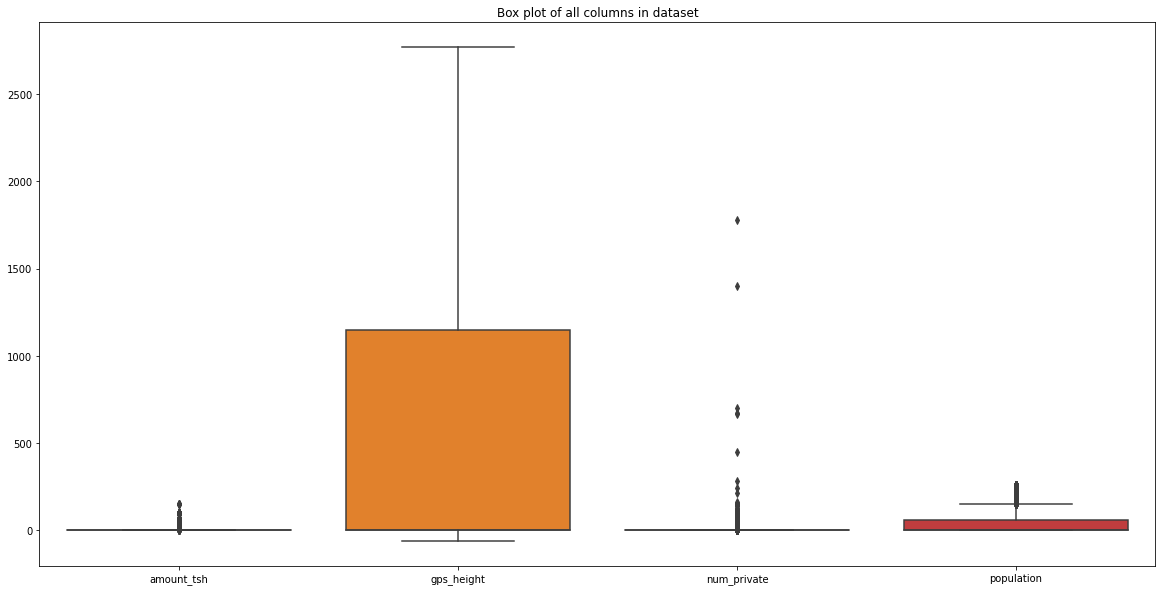

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=[df[col] for col in cont_col])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(0,4), cont_col)
plt.show()

In [ ]:
df.describe()

,id,amount_tsh,gps_height,num_private,population,construction_year
count,40157.000000,40157.000000,40157.000000,40157.000000,40157.000000,40157.000000
mean,37089.431855,4.807547,495.346465,0.542371,44.707299,991.459297
std,21471.981697,15.669995,664.047571,13.994697,75.664181,998.327453
min,0.000000,0.000000,-63.000000,0.000000,0.000000,0.000000
25%,18483.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36969.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55681.000000,0.000000,1149.000000,0.000000,60.000000,2000.000000
max,74246.000000,150.000000,2770.000000,1776.000000,259.000000,2013.000000


There are still quiet a few large outliers but I do not want to aggressively cut them off for now, since it might be important to the classifier.

# Scrubbing Data - Dealing with Missing and Filler Values

In [ ]:
df.isna().sum()


id                          0
status_group                0
amount_tsh                  0
gps_height                  0
num_private                 0
basin                       0
region                      0
district_code               0
population                  0
public_meeting           2503
scheme_management        2258
permit                   2409
construction_year           0
extraction_type_group       0
management_group            0
payment_type                0
water_quality               0
quantity                    0
source                      0
waterpoint_type             0
dtype: int64

Three features have missing value and will have to be dealt with but first I will take a look at the value counts to find the filler values.

In [ ]:
df['status_group'].value_counts()

functional                 20592
non functional             16800
functional needs repair     2765
Name: status_group, dtype: int64

In [ ]:
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(), '\n\n' )


id 
 67583    0.000025
36091    0.000025
19715    0.000025
17666    0.000025
23809    0.000025
Name: id, dtype: float64 


status_group 
 functional                 0.512787
non functional             0.418358
functional needs repair    0.068855
Name: status_group, dtype: float64 


amount_tsh 
 0.0      0.866150
50.0     0.041960
20.0     0.027965
10.0     0.014643
100.0    0.012825
Name: amount_tsh, dtype: float64 


gps_height 
  0     0.497796
-15    0.001021
-13    0.000996
-16    0.000946
-17    0.000872
Name: gps_height, dtype: float64 


num_private 
 0     0.986204
1     0.001419
6     0.001270
8     0.001046
45    0.000896
Name: num_private, dtype: float64 


basin 
 Lake Victoria      0.214458
Pangani            0.159325
Internal           0.149438
Wami / Ruvu        0.104589
Lake Tanganyika    0.093483
Name: basin, dtype: float64 


region 
 Shinyanga      0.120552
Mbeya          0.115522
Kagera         0.082576
Kilimanjaro    0.082252
Mwanza         0.069876
Name: region, 

Filler values found:

- population - 0 ,1
- construction_year - 0
- management_group  - unknown 
- payment_type - unknown
- water_quality - unknown
- quantity - unknown

Some of these fillers make up a large majority of the data so getting rid of them is not ideal. Instead I will look to replace them using KNN Imputer, which replace the value using the K-nearest neighbors values.

First I will replace all the filler values with nan.

In [ ]:
len(df)

40157

In [ ]:
#Replace the 0 and 1 in population column with np.nan
df['population'].replace({0: np.nan, 1:np.nan}, inplace=True)

# #Replace the 0 in construction_year column with np.nan
df['construction_year'].replace({0: np.nan}, inplace=True)

# #Replace the unknown in management_group, payment_type, water_quality, quantity column with np.nan
df['management_group'].replace({'unknwon': np.nan}, inplace=True)
df['payment_type'].replace({'unknwon': np.nan}, inplace=True)
df['water_quality'].replace({'unknwon': np.nan}, inplace=True)
df['quantity'].replace({'unknwon': np.nan}, inplace=True)
df['scheme_management'].replace({'None': np.nan}, inplace=True)

df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
gps_height                   0
num_private                  0
basin                        0
region                       0
district_code                0
population               26386
public_meeting            2503
scheme_management         2259
permit                    2409
construction_year        20216
extraction_type_group        0
management_group             0
payment_type                 0
water_quality                0
quantity                     0
source                       0
waterpoint_type              0
dtype: int64

Since both the 'population' and 'construction_year' columns are missing for half the dataset, I believe it is best to just drop these columns rather than fill them.

In [ ]:
# Drop columns with large missing data
df = df.drop(columns=['population', 'construction_year'], axis=1)


In [ ]:
X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

Before using the KNN Imputer I will need to scale the data first. Since I was not aggresive with cutting off outliers, I will use the StandardScaler insteader of MinMaxScaler which is sensative to outliers.

In [ ]:
to_scaled = ['amount_tsh', 'gps_height', 'num_private']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaled_features_train = X_train_scaled[to_scaled]
scaled_features_test = X_test_scaled[to_scaled]

In [ ]:
scaler = StandardScaler()

# Fitting and transforming the data for the main dataset
X_scaled_train = pd.DataFrame(scaler.fit_transform(scaled_features_train.values), columns= scaled_features_train.columns)
X_scaled_test = pd.DataFrame(scaler.transform(scaled_features_test.values), columns = scaled_features_test.columns)

X_scaled_train.head()

,amount_tsh,gps_height,num_private
0,-0.307201,1.128274,-0.043918
1,-0.307201,-0.745757,-0.043918
2,-0.307201,-0.745757,-0.043918
3,-0.307201,-0.745757,-0.043918
4,1.612900,-0.768372,-0.043918


In [ ]:

X_train_scaled.reset_index(inplace=True)
X_test_scaled.reset_index(inplace=True)


In [ ]:
X_train_scaled[to_scaled] = X_scaled_train
X_test_scaled[to_scaled] = X_scaled_test


In [ ]:
X_train_scaled

,index,id,amount_tsh,gps_height,num_private,basin,region,district_code,public_meeting,scheme_management,permit,extraction_type_group,management_group,payment_type,water_quality,quantity,source,waterpoint_type
0,21383,41736,-0.307201,1.128274,-0.043918,Pangani,Kilimanjaro,4,True,VWC,True,gravity,user-group,never pay,soft,enough,spring,communal standpipe
1,1158,59430,-0.307201,-0.745757,-0.043918,Lake Victoria,Kagera,2,True,VWC,True,gravity,user-group,never pay,soft,seasonal,spring,improved spring
2,25815,37268,-0.307201,-0.745757,-0.043918,Wami / Ruvu,Dodoma,4,True,VWC,True,mono,user-group,per bucket,soft,insufficient,machine dbh,communal standpipe multiple
3,54845,62135,-0.307201,-0.745757,-0.043918,Lake Nyasa,Mbeya,3,True,VWC,True,gravity,user-group,never pay,soft,dry,spring,communal standpipe
4,16725,26732,1.612900,-0.768372,-0.043918,Ruvuma / Southern Coast,Mtwara,1,True,VWC,False,submersible,user-group,per bucket,soft,enough,machine dbh,communal standpipe multiple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30112,24228,62575,-0.307201,1.625805,-0.043918,Pangani,Arusha,2,True,VWC,True,gravity,user-group,never pay,soft,insufficient,spring,communal standpipe
30113,13279,14686,-0.307201,-0.745757,-0.043918,Lake Nyasa,Mbeya,3,True,VWC,True,gravity,user-group,never pay,soft,dry,spring,communal standpipe
30114,8835,40539,-0.307201,-0.745757,-0.043918,Rufiji,Dodoma,1,True,VWC,True,gravity,user-group,never pay,soft,enough,spring,communal standpipe
30115,7924,10538,1.612900,-0.175859,-0.043918,Wami / Ruvu,Pwani,1,True,VWC,True,submersible,user-group,per bucket,salty,enough,machine dbh,communal standpipe


Next I will create dummy variables for categorical data before using the KNN Imputer. I will create two different data, one with drop_first=True to use with Logistic Regression and another to use with other classifier.

In [ ]:
# Creating dummies and dropping one variable to avoid dummy variable trap
X_dummy_logreg = pd.get_dummies(X_train_scaled, drop_first=True)
X_test_dummy_logreg = pd.get_dummies(X_test_scaled, drop_first=True)

X_dummy = pd.get_dummies(X_train_scaled, drop_first=False)
X_test_dummy = pd.get_dummies(X_test_scaled, drop_first=False)


X_dummy_logreg.drop(columns='waterpoint_type_dam', axis=1, inplace=True)
X_dummy.drop(columns='waterpoint_type_dam', axis=1, inplace=True)

Now that the data is normalize we can now use the KNN Imputer.

In [ ]:
# I will use the nearest 5 neighbors to impute
imputer = KNNImputer(n_neighbors=5)

In [ ]:
X_train_logreg_impute = pd.DataFrame(imputer.fit_transform(X_dummy_logreg),columns = X_dummy_logreg.columns)
X_test_logreg_impute = pd.DataFrame(imputer.transform(X_test_dummy_logreg),columns = X_test_dummy_logreg.columns)


In [ ]:
X_train = pd.DataFrame(imputer.fit_transform(X_dummy),columns = X_dummy.columns)
X_test = pd.DataFrame(imputer.transform(X_test_dummy),columns = X_test_dummy.columns)


In [ ]:
X_train.head()

,index,id,amount_tsh,gps_height,num_private,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,district_code_0,district_code_1,district_code_13,district_code_2,district_code_23,...,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,21383.0,41736.0,-0.307201,1.128274,-0.043918,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1158.0,59430.0,-0.307201,-0.745757,-0.043918,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25815.0,37268.0,-0.307201,-0.745757,-0.043918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,54845.0,62135.0,-0.307201,-0.745757,-0.043918,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,16725.0,26732.0,1.612900,-0.768372,-0.043918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Checking For Class Imbalance

Now I will test for class imbalance since if there is one, the performance measurements will be unreliable.

In [ ]:
print(y_train_logreg.value_counts(normalize=True))
print('\n')
print(y_train.value_counts(normalize=True))



functional                 0.514593
non functional             0.416111
functional needs repair    0.069296
Name: status_group, dtype: float64


functional                 0.514593
non functional             0.416111
functional needs repair    0.069296
Name: status_group, dtype: float64


The fuctional category makes up 51% and the non functional category makes up 41% of the training dataset. The problem lies with the functional needs repair category which make up only 7% of the dataset. Since it is important for the authorities to know which water points need repairs, I will fix this imbalance by using the SMOTE(Synthetic Minority Oversampling) tool.

In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_logreg_impute_resampled, y_train_logreg_resampled = smote.fit_resample(X_train_logreg_impute, y_train_logreg)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Now I will check again to see if the class imbalance is fixed.

In [ ]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns )
y_train_resampled = pd.Series(y_train_resampled, name='status_group')
X_train_logreg_impute_resampled = pd.DataFrame(X_train_logreg_impute_resampled, columns=X_train_logreg_impute.columns)
y_train_logreg_resampled = pd.Series(y_train_resampled, name='status_group')


In [ ]:
print(y_train_resampled.value_counts(normalize=True))
print('\n')
print(y_train_logreg_resampled.value_counts(normalize=True))



non functional             0.333333
functional                 0.333333
functional needs repair    0.333333
Name: status_group, dtype: float64


non functional             0.333333
functional                 0.333333
functional needs repair    0.333333
Name: status_group, dtype: float64


The categories are now all equal at 33.33% each. Solving the class imbalance problem. I will now combine the data into a dataframe again to make things simpler.

In [ ]:
# Combining the training data to make easy to keep track
processed_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)
processed_df_logreg = pd.concat([X_train_logreg_impute_resampled, y_train_logreg_resampled], axis=1)

processed_df = processed_df.drop(columns=['id', 'index'])
processed_df_logreg = processed_df_logreg.drop(columns=['id', 'index'])



In [ ]:
# Resetting index so it could be combine with the features
y_test.reset_index(drop=True, inplace=True)
y_test_logreg.reset_index(drop=True, inplace=True)


In [ ]:
# Combining test data into a dataframe

processed_test_df= pd.concat([X_test, y_test], axis=1)
processed_test_df_logreg = pd.concat([X_test_logreg_impute, y_test_logreg], axis=1)

processed_test_df = processed_test_df.drop(columns=['id', 'index'])
processed_test_df_logreg = processed_test_df_logreg.drop(columns=['id', 'index'])

Now that I am done with scrubbing and exploring the data, I will start to build the models.

# Building the Models

For this project I will be building several models using diffrent classifiers and then compare the performance metrics to choose one classifier. I will be using CVsearch and param grids to make sure the model the parameters are well chosen.

The classifiers I will be trying out are

- Logistic Regression
- K-Nearest Neighbour
- Decision Tree Classifier
- Randomn Forest Classifier
- eXtreme Gradient Boosting (XGBoost)
- Support Vector Machines (SVM)

The performance metrics I will be using are Precision, Recall, Accuracy, and F1 Score. I will also be investigating the confusion matrix.

Before we build the models, I will create a fuction that takes in the model, the true data and the predictions and then append the performance metrics to a dataframe. After having create all the models, we can compare the scores at the end.

In [ ]:
scores_df = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'Accuracy', 'F1'])

# Creating the function
def find_scores(model, y_test, y_test_hat):
  '''
  parameters : (model:classifier model, y true value, y predicted value)

  Save precision, recall, accuracy, and f1 scores to a dataframe
  '''
  global scores_df

  # Calculating test scores
  precision = precision_score(y_test, y_test_hat, average='weighted')
  recall = recall_score(y_test, y_test_hat, average='weighted')
  accuracy = accuracy_score(y_test, y_test_hat)
  f1 = f1_score(y_test, y_test_hat, average='weighted')

  # Adding the scores into the dataframe
  scores_df = scores_df.append({'Model':model, 'Precision':precision, 'Recall':recall, 'Accuracy':accuracy, 'F1':f1}, ignore_index=True)

## Logistic Regression
The first model I will be creating is Logistic Regression. We will first create a base model with the default hyperparameters, before using GridSearchCV to find optimal parameters.

In [ ]:
processed_df_logreg.head(2)

,amount_tsh,gps_height,num_private,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,district_code_1,district_code_13,district_code_2,district_code_23,district_code_3,district_code_30,district_code_33,district_code_4,district_code_43,...,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,status_group
0,-0.307201,1.128274,-0.043918,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,functional
1,-0.307201,-0.745757,-0.043918,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,non functional


In [ ]:
processed_test_df_logreg.head(2)

,amount_tsh,gps_height,num_private,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,district_code_1,district_code_13,district_code_2,district_code_23,district_code_3,district_code_30,district_code_33,district_code_4,district_code_43,...,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,status_group
0,-0.307201,-0.768372,-0.043918,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,non functional
1,-0.307201,-0.745757,-0.043918,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,functional needs repair


In [ ]:
X = processed_df_logreg.drop(columns=['status_group'], axis=1)
y = processed_df_logreg['status_group']
 
X_test = processed_test_df_logreg.drop(columns=['status_group'], axis=1)
y_test = processed_test_df_logreg['status_group']

logreg_default = LogisticRegression(fit_intercept=True, solver='liblinear')
logreg_default.fit(X, y)

# y_preds_logreg = logreg.predict(X_test_logreg_impute)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

[[0.60227719 0.29151943 0.10620338]
 [0.22861357 0.67846608 0.09292035]
 [0.20923149 0.16447985 0.62628866]]


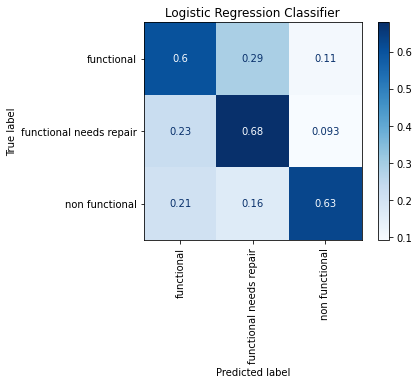

In [ ]:
disp = plot_confusion_matrix(logreg_default, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('Logistic Regression Classifier')

print(disp.confusion_matrix)


We can see that the Logistic Regression didn't do that great a job classifying the data. The true positive rate for all three categories does not exceed 0.7

Next we will take a look at the scores from the classification report and see what is going on.

In [ ]:
# Predicting using the model
y_train_hat = logreg_default.predict(X)
y_test_hat = logreg_default.predict(X_test)

# Printing out the scores
print('logreg_default')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))

logreg_default
Training Data
                         precision    recall  f1-score   support

             functional       0.62      0.61      0.61     15498
functional needs repair       0.62      0.72      0.67     15498
         non functional       0.76      0.65      0.70     15498

               accuracy                           0.66     46494
              macro avg       0.67      0.66      0.66     46494
           weighted avg       0.67      0.66      0.66     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.75      0.60      0.67      5094
functional needs repair       0.17      0.68      0.28       678
         non functional       0.82      0.63      0.71      4268

               accuracy                           0.62     10040
              macro avg       0.58      0.64      0.55     10040
           weighted avg       0.74      0.62      0.66     10040



The f1-score for two of the categories actually increased for the testing data, but for the 'functional needs repair' category decreased by a lot. The overall 'accuracy' is only 0.61 which would make it just slightly better than random choice. The default LogisticRegression doesn't seem that promising so I will try changing the regularization parameter.

In [ ]:
find_scores('LogisticRegression Default', y_test, y_test_hat)

Next I will be using the GridSearchCV to find the best regularization parameter.

In [ ]:

# Set the grid for the GridSearchCV
# To save computing time I will comment out the parameters, just write the optimal ones
grid = [{'C': [1, 1000000, 1e16]}]


## Instantiate GridSearchCV
# logreg_gs = GridSearchCV(estimator=logreg_default, 
#                           param_grid=grid, 
#                           scoring='accuracy', 
#                           cv=5)

logreg_gs = LogisticRegression(fit_intercept=True, solver='liblinear', C= 1000000)
# Fitting The Data
logreg_gs.fit(X, y)

# Show the best parameters
#print(f"Best Parameters: {logreg_gs.best_params_}")
print("Best Parameters: {'C': 1000000}")

Best Parameters: {'C': 1000000}


GridSearchCV showed that the optimal parameter is C = 1000000 which is diffrent from the default of value of 1. Next I will take a look at the Confusion Matrix and the Classification Report to see how the performance change.

[[0.60345505 0.28975265 0.1067923 ]
 [0.22713864 0.67846608 0.09439528]
 [0.20899719 0.16541706 0.62558575]]
LogisticRegression GridSearch
Training Data
                         precision    recall  f1-score   support

             functional       0.62      0.61      0.61     15498
functional needs repair       0.62      0.72      0.67     15498
         non functional       0.76      0.65      0.70     15498

               accuracy                           0.66     46494
              macro avg       0.67      0.66      0.66     46494
           weighted avg       0.67      0.66      0.66     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.75      0.60      0.67      5094
functional needs repair       0.17      0.68      0.28       678
         non functional       0.81      0.63      0.71      4268

               accuracy                           0.62     10040
              macro avg       0.58      0.64   

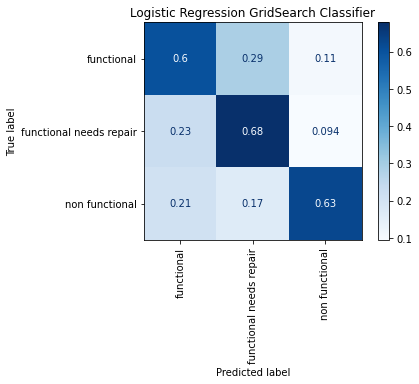

In [ ]:
disp = plot_confusion_matrix(logreg_gs, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('Logistic Regression GridSearch Classifier')

print(disp.confusion_matrix)

# Predicting using the model
y_train_hat = logreg_gs.predict(X)
y_test_hat = logreg_gs.predict(X_test)

# Printing out the scores
print('LogisticRegression GridSearch')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))


# Update the scores dataframe
find_scores('LogisticRegression GridSearch', y_test, y_test_hat)

The gridsearch changed the parameter for c from 1 to 1000000 but the results for the Confusion Matrix and the scoring metrics hardly changed at all. The f1-score for the 'functional needs repair' category again drop by alot for the testing dataset. I will have to compare the score to those of other models, but Logistic Regression doesn't seem to be the answer.

The next classifier that I will be using is K-nearest neighbour. A version of which we already used to fill in the missing values in our datasets.

# K-Nearest Neighbors Classifier

I will be using GridSearchCV to find the optimal n_neighbors and leaf_size.

In [ ]:
#The dataframes we will be using from now on.
# processed_df
# processed_test_df

X = processed_df.drop(columns=['status_group'], axis=1)
y = processed_df['status_group']

X_test = processed_test_df.drop(columns=['status_group'], axis=1)
y_test = processed_test_df['status_group']

# Set the grid for the GridSearchCV
# grid = [{'leaf_size': [20, 30, 40], 
#          'n_neighbors': [3, 5, 7]}]


## Instantiate KNeighborsClassifier
# clf = KNeighborsClassifier()

## Instantiate GridSearchCV
# KNN_gs = GridSearchCV(estimator=clf, 
#                           param_grid=grid, 
#                           scoring='accuracy', 
#                           cv=5)


# To save computational time I will use a use the normal classifier using the parameters found using GridSearchCV
KNN_gs = KNeighborsClassifier(leaf_size= 20, n_neighbors= 3)
## Fitting The Data
KNN_gs.fit(X, y)

# Show the best parameters
# print(f"Best Parameters: {KNN_gs.best_params_}")
print("Best Parameters: {'leaf_size': 20, 'n_neighbors': 3}")

Best Parameters: {'leaf_size': 20, 'n_neighbors': 3}


GridSearchCV has shown the best parameters are 20 for leaf_size and 3 for n_neighbors. Next I will take a look at the confusion matrix and classification reports to see how the model performs.

In [ ]:
# Predicting using the model
y_train_hat = KNN_gs.predict(X)
y_test_hat = KNN_gs.predict(X_test)



# Update the scores dataframe
find_scores('K-Nearest Neighbor GS', y_test, y_test_hat)

[[0.79308991 0.06988614 0.13702395]
 [0.51179941 0.35693215 0.13126844]
 [0.21930647 0.052015   0.72867854]]
K-Nearest Neighbors GridSearch Classifier
Training Data
                         precision    recall  f1-score   support

             functional       0.82      0.87      0.84     15498
functional needs repair       0.91      0.92      0.92     15498
         non functional       0.89      0.82      0.85     15498

               accuracy                           0.87     46494
              macro avg       0.87      0.87      0.87     46494
           weighted avg       0.87      0.87      0.87     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.76      0.79      0.78      5094
functional needs repair       0.30      0.36      0.32       678
         non functional       0.80      0.73      0.76      4268

               accuracy                           0.74     10040
              macro avg       0.62 

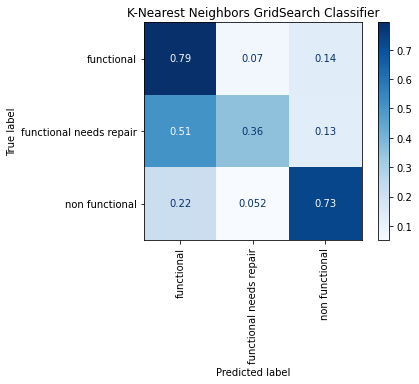

In [ ]:
disp = plot_confusion_matrix(KNN_gs, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('K-Nearest Neighbors GridSearch Classifier')

print(disp.confusion_matrix)


# Printing out the scores
print('K-Nearest Neighbors GridSearch Classifier')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))


The K-Nearest Neighbors performs better than Logistic Regression for all three categories. The performance metrics for the test data is  worse than it is for the training data, especially for the 'functional needs repair' category. This perhaps hints at overfitting. If the f-1 score for the 'functional needs repairs' category is low for all models, I would need to pay more attention to the recall score of this category which I believe is a little more imporant than the precision score is for our purpose. This model seems to be extremely flaw and not ideal.

# Decision Tree Classifier
The next model we will be taking a look is a single Decision Tree Classifier. I will be performing a grid search for criterion, max_depth, min_samples_split and also min_samples_leaf.

In [ ]:
X = processed_df.drop(columns=['status_group'], axis=1)
y = processed_df['status_group']

X_test = processed_test_df.drop(columns=['status_group'], axis=1)
y_test = processed_test_df['status_group']

# Set the grid for the GridSearchCV
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}


# Instantiate DecisionTreeClassifier
# dt_clf = tree.DecisionTreeClassifier(random_state=21)  

# Instantiate GridSearchCV
# dt_clf_gs = GridSearchCV(estimator=dt_clf, 
#                           param_grid=dt_param_grid, 
#                           scoring='accuracy', 
#                           cv=5)

# To save computational time I will use a use the normal classifier using the parameters found using GridSearchCV
dt_clf_gs = tree.DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=3, min_samples_split=5)

# Fitting The Data
dt_clf_gs.fit(X, y)

# Show the best parameters
# print(f"Best Parameters: {dt_clf_gs.best_params_}")
print("Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5}")

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5}


[[0.83725952 0.03180212 0.13093836]
 [0.51179941 0.32300885 0.16519174]
 [0.23922212 0.0269447  0.73383318]]
Decision Tree GridSearch Classifier
Training Data
                         precision    recall  f1-score   support

             functional       0.83      0.92      0.87     15498
functional needs repair       0.95      0.91      0.93     15498
         non functional       0.90      0.85      0.88     15498

               accuracy                           0.89     46494
              macro avg       0.90      0.89      0.89     46494
           weighted avg       0.90      0.89      0.89     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.76      0.84      0.80      5094
functional needs repair       0.44      0.32      0.37       678
         non functional       0.80      0.73      0.77      4268

               accuracy                           0.76     10040
              macro avg       0.67      0

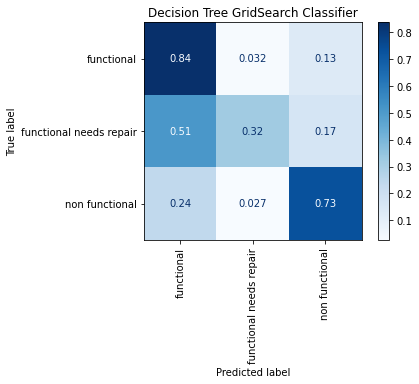

In [ ]:
disp = plot_confusion_matrix(dt_clf_gs, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('Decision Tree GridSearch Classifier')

print(disp.confusion_matrix)

# Predicting using the model
y_train_hat = dt_clf_gs.predict(X)
y_test_hat = dt_clf_gs.predict(X_test)

# Printing out the scores
print('Decision Tree GridSearch Classifier')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))


# Update the scores dataframe
find_scores('Decision Tree Classifier GS', y_test, y_test_hat)

Once again the model does a poor job of predicting the 'functional needs repair' category. The accuracy for the test data set is only 0.73 compared to 0.86 of the training data set showing there might be overfitting. The f1-score is also much worse in the test data set for all categories, especially for 'functional needs repair' category. The scores are nearly identical with those of K-nearest Neighbours. The recall score which I believe to be more important for our purpose in identifying water points that need repairs is larger in this the model than in the previous ones.


# Random Forest Classifier
The next model we will testing is Random Forest, an ensemble method classifier. I am hoping that esemble methods perform better than the previous models.

Again I will use GridSearchCV to search for the best parameters. This time I will take a look at five diffrent parameters in the GridSearchCV.

In [ ]:
X = processed_df.drop(columns=['status_group'], axis=1)
y = processed_df['status_group']

X_test = processed_test_df.drop(columns=['status_group'], axis=1)
y_test = processed_test_df['status_group']

# Set the grid for the GridSearchCV
rf_param_grid = {
    'n_estimators': [30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}


# Instantiate RandomForestClassifier
# rf_clf = RandomForestClassifier(random_state=21)  

# Instantiate GridSearchCV
# rf_clf_gs = GridSearchCV(estimator=rf_clf, 
#                           param_grid=rf_param_grid, 
#                           scoring='accuracy', 
#                           cv=5)

# To save computational time I will use a use the normal classifier using the parameters found using GridSearchCV
rf_clf_gs = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100)

# Fitting The Data
rf_clf_gs.fit(X, y)

# Show the best parameters
# print(f"Best Parameters: {rf_clf_gs.best_params_}")
print("Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}")

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


[[0.86415391 0.02277189 0.1130742 ]
 [0.5339233  0.30235988 0.16371681]
 [0.21836926 0.01569822 0.76593252]]
Random Forest GridSearch Classifier
Training Data
                         precision    recall  f1-score   support

             functional       0.84      0.93      0.88     15498
functional needs repair       0.97      0.92      0.94     15498
         non functional       0.92      0.86      0.89     15498

               accuracy                           0.90     46494
              macro avg       0.91      0.90      0.90     46494
           weighted avg       0.91      0.90      0.90     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.77      0.86      0.82      5094
functional needs repair       0.53      0.30      0.38       678
         non functional       0.83      0.77      0.79      4268

               accuracy                           0.78     10040
              macro avg       0.71      0

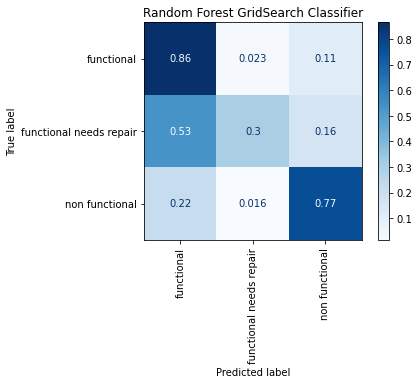

In [ ]:
disp = plot_confusion_matrix(rf_clf_gs, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('Random Forest GridSearch Classifier')

print(disp.confusion_matrix)

# Predicting using the model
y_train_hat = rf_clf_gs.predict(X)
y_test_hat = rf_clf_gs.predict(X_test)

# Printing out the scores
print('Random Forest GridSearch Classifier')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))


# Update the scores dataframe
find_scores('Random Forest Classifier GS', y_test, y_test_hat)

The Random Forest Classifier did a slightly better job identifying funtional and non functional categories than the other classifiers but still struggle with identifying functional needs repair category.

The f-1 scores for the test dataset is lower than the training dataset but still  decent, expect for the functional needs repair category. The accuracy also decrease by quiet a lot when comparing between the training and testing datasets but is not that bad at 0.75.

# XGBoost (eXtreme Gradient Boosting)

The next classifier I will take a look at is XGBoost and I will be searching out the best values for 5 diffrent parameters.

In [ ]:
X = processed_df.drop(columns=['status_group'], axis=1)
y = processed_df['status_group']

X_test = processed_test_df.drop(columns=['status_group'], axis=1)
y_test = processed_test_df['status_group']

# Set the grid for the GridSearchCV
xgb_param_grid = {
    "learning_rate": [0.1, 0.3],
    'max_depth': [6],
    'min_child_weight': [1, 10],
    'subsample': [ 0.7, 1],
    'n_estimators': [30, 100, 250],
}

# Instantiate XGBoost
# xgb_clf = xgb.XGBClassifier()
# Instantiate GridSearchCV
# xgb_clf_gs = GridSearchCV(xgb_clf, xgb_param_grid, scoring='accuracy', cv=None, n_jobs=1)


# To save computational time I will use a use the normal classifier using the parameters found using GridSearchCV
xgb_clf_gs = xgb.XGBClassifier(learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=250, subsample=0.7)

# # Fitting The Data
xgb_clf_gs.fit(X, y)

# Show the best parameters
# print(f"Best Parameters: {xgb_clf_gs.best_params_}")
print("Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.7}")

Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.7}


Using GridSearchCV, I managed to find the best parameters out of the ones that I passed into it. The best values for 'learning_rate', 'max_depth' and 'min_child_weight' are all found to be the default values. 'n_estimators' is found to be 250 and 'subsample' as 0.7.

Now I will take a look at the confusion matrix and the classification report to see how the model performs.

[[0.87063212 0.02453867 0.10482921]
 [0.54572271 0.30088496 0.15339233]
 [0.22235239 0.01663543 0.76101218]]
XGBoost GridSearch Classifier
Training Data
                         precision    recall  f1-score   support

             functional       0.83      0.92      0.87     15498
functional needs repair       0.97      0.92      0.95     15498
         non functional       0.91      0.86      0.88     15498

               accuracy                           0.90     46494
              macro avg       0.91      0.90      0.90     46494
           weighted avg       0.91      0.90      0.90     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.77      0.87      0.82      5094
functional needs repair       0.51      0.30      0.38       678
         non functional       0.84      0.76      0.80      4268

               accuracy                           0.79     10040
              macro avg       0.71      0.64   

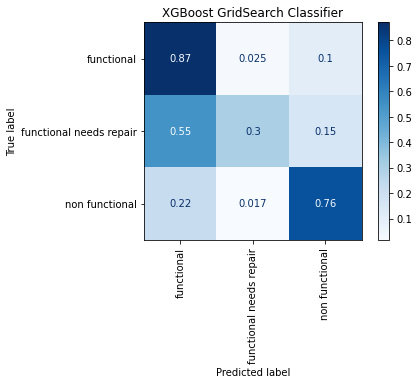

In [ ]:
disp = plot_confusion_matrix(xgb_clf_gs, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('XGBoost GridSearch Classifier')

print(disp.confusion_matrix)

# Predicting using the model
y_train_hat = xgb_clf_gs.predict(X)
y_test_hat = xgb_clf_gs.predict(X_test)

# Printing out the scores
print('XGBoost GridSearch Classifier')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))


# Update the scores dataframe
find_scores('XGBoost Classifier GS', y_test, y_test_hat)

The confusion matrix for XGBoost seems similar to RandomForest Classifier. The accuracy and weighted f1-score is nearly identical to those of RandomForest Classifier also.

# SVM (Support Vector Machines)

The next classifier is SVM and I will taking a look at C and gamma parameters.

In [ ]:
X = processed_df.drop(columns=['status_group'], axis=1)
y = processed_df['status_group']

# Set the grid for the GridSearchCV
svm_param_grid = {'C': [0.01, 0.1, 1, 10],
              'gamma' : [0.01, 1, 'scale']}

# Instantiate SVM
# svm_clf = svm.SVC(kernel='rbf')   

# Instantiate GridSearchCV
# svm_gs = GridSearchCV(svm_clf, svm_param_grid, scoring='accuracy', cv=3)

# To save computational time I will use a use the normal classifier using the parameters found using GridSearchCV
svm_gs = svm.SVC(kernel='rbf', C=10, gamma=0.01)   
# Fitting The Data
svm_gs.fit(X, y)

# Show the best parameters
# print(f"Best Parameters: {svm_gs.best_params_}")
print("Best Parameters: {'C': 10, 'gamma': 0.01}")

Best Parameters: {'C': 10, 'gamma': 0.01}


[[0.8619945  0.035532   0.1024735 ]
 [0.54572271 0.33923304 0.11504425]
 [0.28467666 0.02905342 0.68626992]]
SVM GridSearch Classifier
Training Data
                         precision    recall  f1-score   support

             functional       0.72      0.87      0.79     15498
functional needs repair       0.89      0.82      0.86     15498
         non functional       0.82      0.70      0.76     15498

               accuracy                           0.80     46494
              macro avg       0.81      0.80      0.80     46494
           weighted avg       0.81      0.80      0.80     46494



Testing Data
                         precision    recall  f1-score   support

             functional       0.73      0.86      0.79      5094
functional needs repair       0.43      0.34      0.38       678
         non functional       0.83      0.69      0.75      4268

               accuracy                           0.75     10040
              macro avg       0.66      0.63      0

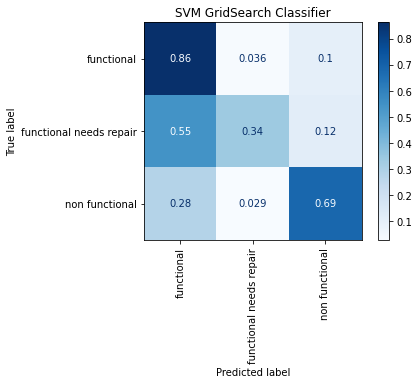

In [ ]:
disp = plot_confusion_matrix(svm_gs, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation='vertical')
disp.ax_.set_title('SVM GridSearch Classifier')

print(disp.confusion_matrix)

# Predicting using the model
y_train_hat = svm_gs.predict(X)
y_test_hat = svm_gs.predict(X_test)

# Printing out the scores
print('SVM GridSearch Classifier')
print('Training Data')
print(classification_report(y, y_train_hat))
print('\n')
print('Testing Data')
print(classification_report(y_test, y_test_hat))


# Update the scores dataframe
find_scores('SVM Classifier GS', y_test, y_test_hat)

The scores are worse than XGBoost and RandomForest.

# Selecting Model

Now I will compare all the scores for all the models that I built so far. I will be mainly taking a look at F1-score and Accuracy.

In [ ]:
scores_df.sort_values('F1', ascending=False)

,Model,Precision,Recall,Accuracy,F1
5,XGBoost Classifier GS,0.780812,0.785558,0.785558,0.779078
4,Random Forest Classifier GS,0.779064,0.784462,0.784462,0.777907
3,Decision Tree Classifier GS,0.754397,0.758566,0.758566,0.754218
6,SVM Classifier GS,0.754658,0.751992,0.751992,0.747497
2,K-Nearest Neighbor GS,0.744259,0.736255,0.736255,0.739199
1,LogisticRegression GridSearch,0.736568,0.617928,0.617928,0.658080
0,LogisticRegression Default,0.736669,0.617629,0.617629,0.657915


Text(0.5, 1.0, 'Classifier Scores')

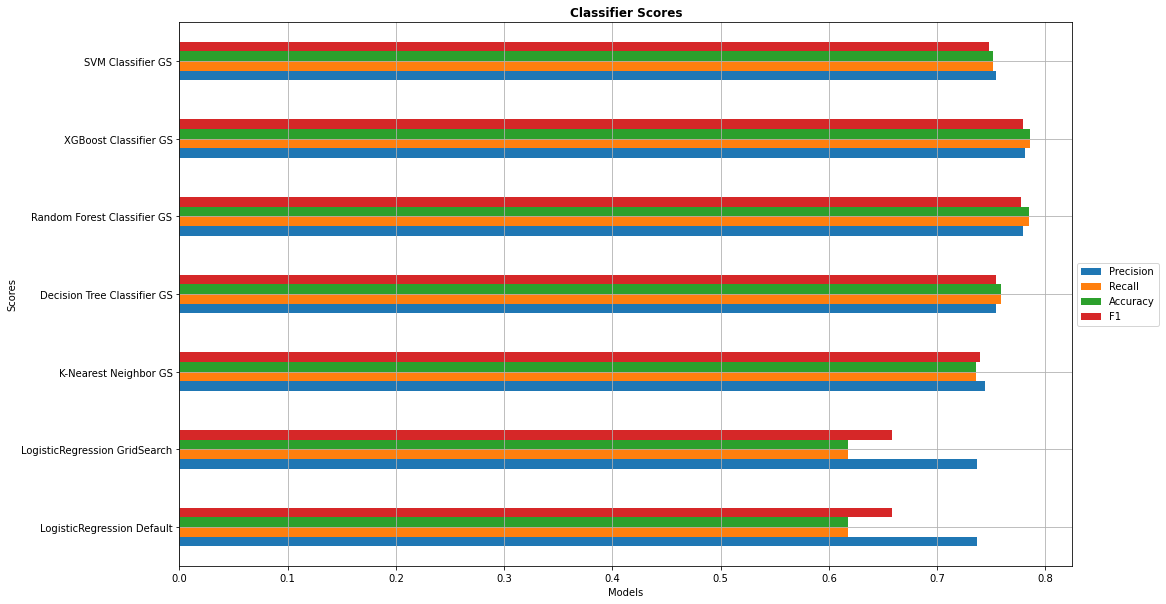

In [ ]:
scores_df.plot(x='Model', kind='barh', figsize=(16,10), grid=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Classifier Scores',fontweight="bold")

## RandomForest vs XGBoost vs LogisticRegression

XGBoost and Random Forest classifiers seems to perform the best with XGBoost having a slight edge.

Another classifier that I believe should be considered is LogisticRegression. Which despite having a worse F1 and Accuracy scores than several other models, have the highest recall score for the 'functional needs repair' category. This is a category that all of our models struggle identifying.



#### RandomForest

                          
                                  precision    recall  f1-score   

                     functional       0.80      0.77      0.78      
        functional needs repair       0.30      0.31      0.39     
                 non functional       0.82      0.75      0.78      

#### XGBoost

                          
                                  precision    recall  f1-score   

                     functional       0.79      0.77      0.78      
        functional needs repair       0.30      0.30      0.38     
                 non functional       0.82      0.75      0.78      


#### LogisticRegression

                                  precision    recall  f1-score   

                    functional       0.75      0.60      0.67      
        functional needs repair      0.17      0.68      0.28       
                 non functional      0.81      0.63      0.71      

For the purpose of this project it is important to identify the 'non functional' and 'functional needs repair' categories so that the Tanzania goverment can repair them. High recall would give us the abilty to find more of the waterpoints that need repairs but at the same time also increase the false positive. Which would mean the model would identify functional water points as needing repair, which is also undesirable since it would waste manpower and budget.

Therefore I believe a balance between Precision and Recall (ie. the F1 score) and Accuracy score is more important than just the Recall scores. Therefore I decided choose RandomForest Classifier.


Next I will take a look at the most important features for our model.

# Important Features

In [ ]:
# Create a list of features sorted by importantce
features_rank = pd.Series(rf_clf_gs.feature_importances_,index=X.columns).sort_values(ascending=False)
features_rank

quantity_dry                        0.079813
gps_height                          0.060362
extraction_type_group_gravity       0.040597
quantity_enough                     0.039536
permit_True                         0.034760
                                      ...   
district_code_0                     0.000112
water_quality_fluoride abandoned    0.000072
district_code_62                    0.000052
district_code_80                    0.000049
district_code_67                    0.000002
Length: 122, dtype: float64

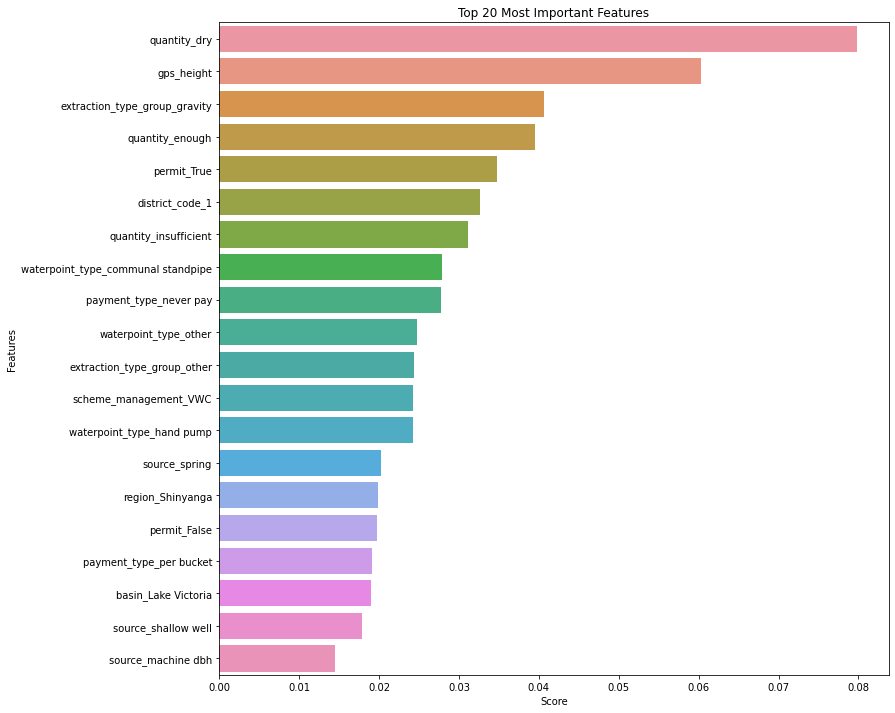

In [ ]:
# Creating a bar plot with the top 20 features
plt.figure(figsize=(12,12))
sns.barplot(x=features_rank[0:20], y=features_rank[0:20].index)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title("Top 20 Most Important Features")
plt.show()

Looking at the top 20 most important features a lot of them seems to be intuitively correct. 

The gps_height column show the altitude of the waterpoint and is considered to be the second most important features for our classifier.

The quantity_dry, quantity_insufficient, and quantity_enough features are dummy variables are obvious why they are important. A dry well or one without insufficient water would obviously be classifed as non functional.

Several waterpoint types  and some extraction types also seems to be important in determining the condition. Perhaps the types that falls under some of these categories are not durable and should be avoided in the future.

A few District and regions are also included in the top twenty features. This warrants a closer inspection to see which districts have more nonfunctional water points and the reason why this might be.


# Prediction
Now that we have our model, I will use it to predict the test dataset without labels given to us.

In [ ]:
# read in the data
prediction_df = pd.read_csv('/content/test_set_values.csv')
prediction_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [ ]:
#Drop all the columns we did not use
prediction_df.drop(columns=['date_recorded', 'funder', 'wpt_name', 'recorded_by', 'management', 'scheme_name', 'extraction_type', 'extraction_type_class',
                            'source_type', 'source_class','quality_group', 'quantity_group','payment', 'waterpoint_type_group',
                            'installer', 'longitude', 'latitude', 'subvillage', 'ward', 'lga', 'region_code', 'population', 'construction_year'], axis=1, inplace=True)


In [ ]:
prediction_df.isna().sum()

id                         0
amount_tsh                 0
gps_height                 0
num_private                0
basin                      0
region                     0
district_code              0
public_meeting           821
scheme_management        969
permit                   737
extraction_type_group      0
management_group           0
payment_type               0
water_quality              0
quantity                   0
source                     0
waterpoint_type            0
dtype: int64

In [ ]:
# #Replace the unknown in management_group, payment_type, water_quality, quantity column with np.nan
prediction_df['management_group'].replace({'unknwon': np.nan}, inplace=True)
prediction_df['payment_type'].replace({'unknwon': np.nan}, inplace=True)
prediction_df['water_quality'].replace({'unknwon': np.nan}, inplace=True)
prediction_df['quantity'].replace({'unknwon': np.nan}, inplace=True)

prediction_df['district_code'] = prediction_df['district_code'].astype(str) 

prediction_df.isna().sum()

id                         0
amount_tsh                 0
gps_height                 0
num_private                0
basin                      0
region                     0
district_code              0
public_meeting           821
scheme_management        969
permit                   737
extraction_type_group      0
management_group           0
payment_type               0
water_quality              0
quantity                   0
source                     0
waterpoint_type            0
dtype: int64

In [ ]:
to_scaled = ['amount_tsh', 'gps_height', 'num_private']

prediction_scaled_df = prediction_df.copy()

scaled_features_prediction = prediction_scaled_df[to_scaled]

# Fitting and transforming the data for the main dataset
prediction_scaled = pd.DataFrame(scaler.fit_transform(scaled_features_prediction.values), columns= scaled_features_prediction.columns)
prediction_scaled_df.reset_index(inplace=True)
prediction_scaled_df[to_scaled] = prediction_scaled
prediction_scaled_df.head()



,index,id,amount_tsh,gps_height,num_private,basin,region,district_code,public_meeting,scheme_management,permit,extraction_type_group,management_group,payment_type,water_quality,quantity,source,waterpoint_type
0,0,50785,-0.128571,1.939784,-0.050821,Internal,Manyara,3,True,Parastatal,True,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other
1,1,51630,-0.128571,1.322052,-0.050821,Pangani,Arusha,2,True,VWC,True,gravity,user-group,never pay,soft,insufficient,spring,communal standpipe
2,2,17168,-0.128571,1.319159,-0.050821,Internal,Singida,2,True,VWC,NaN,other,user-group,never pay,soft,insufficient,rainwater harvesting,other
3,3,45559,-0.128571,-0.561525,-0.050821,Ruvuma / Southern Coast,Lindi,43,NaN,VWC,True,other,user-group,unknown,soft,dry,shallow well,other
4,4,49871,0.070562,0.875028,-0.050821,Ruvuma / Southern Coast,Ruvuma,3,NaN,Water Board,True,gravity,user-group,monthly,soft,enough,spring,communal standpipe


In [ ]:
# Create dummy variables for the categorical columns
prediction_dummies = pd.get_dummies(prediction_scaled_df, drop_first=False)

prediction_dummies.drop(columns=['waterpoint_type_dam'], axis=1, inplace=True)

# Fill in the missing values using KNN imputer
prediction_dummies = pd.DataFrame(imputer.transform(prediction_dummies),columns = prediction_dummies.columns)


In [ ]:
X_prediction = prediction_dummies.drop(columns=['id', 'index'], axis=1)
prediction_dummies['status_group'] = rf_clf_gs.predict(X_prediction)

In [ ]:
prediction_dummies['status_group'].value_counts()

functional                 8670
non functional             5678
functional needs repair     502
Name: status_group, dtype: int64

In [ ]:
submission_form = prediction_dummies['status_group']
submission_form.head(5)

0    non functional
1        functional
2    non functional
3    non functional
4        functional
Name: status_group, dtype: object

# Improvements

- Since using GridSearchCV take up a lot of computational time, I couldn't put in more parameters like I wanted. Searching out more parameters might improve the model performance.

- The model ability to predict functional needs repair is still lacking. I could try scrubbing the data in a diffrent way to make the model better.

- Try out different types of filling missing values to see if it improve the model.

- Instead of dropping the 'population' and 'year_construct' column, find a diffrent way to deal with them.